# Week 3 Homework

## OGLE lightcurve fit

This week you will do your first MCMC fit of real data (for this class)!

# REMINDER!!!

Before doing **anything**,

1. **Make a copy** of this notebook in your clone of the **private** course repository. Edit that copy, not the version in the public repository clone.

2. Remember that you will submit your solution by pull request to the **private** repository.

Once you've submitted your solution, don't forget to also fill out the very quick (and required!) [weekly feedback form](https://docs.google.com/forms/d/e/1FAIpQLSfH0JGjJd67ANAOcUiRT54nmYtQHViKyOQe-20cny3GDytV6Q/viewform?usp=sf_link).

# Additional reminder!

Next week's tutorial will be "Final project speed dating". Grad students should show up on Wednesday with some kind of concept for a final project, however half-baked. Undergrads are encouraged to do so as well, but not required.

### Data

We'll be analyzing data from the Optical Gravitational Lensing Experiment (OGLE), which monitors stars in our galaxy in the hopes of detecting gravitational microlensing events that occur when a compact mass (e.g. a fainter star) passes in front of the monitored star.

Data are available through the [OGLE Early Warning System](http://ogle.astrouw.edu.pl/ogle4/ews/ews.html). Scroll down a bit to the list of recent events and choose one to analyze. (Not the one shown below. Be original.) The event summary page will include a plot like this.

<table>
    <tr>
        <td><img src="http://ogle.astrouw.edu.pl/ogle4/ews/2016/data/2016/blg-0001/lcurve.gif" width=75%></td>
    </tr>
</table>

As long as a vaguely reasonable looking magenta line is shown, this should be a good data set to fit. Download the `phot.dat` for your chosen event (linked at the bottom of the webpage).

As described on the OGLE page, the columns of this text file are

> Hel.JD, I magnitude, magnitude error, seeing estimation (in pixels - 0.26"/pixel) and sky level

* Heliocentric Julian Date. This is time, measured in days, since a fixed reference. The "heliocentric" part means that it has been corrected to the reference frame of the Sun, i.e. the few minutes of light travel time more or less that would affect photon arrivals at different parts of the Earth's year have been subtracted off.

* Measurements of magnitude in the $I$ band (a near infrared band). Recall that astronomical magnitude, relative to a given reference source, is given by the relationship $m = m_\mathrm{ref} - 2.5\,\log_{10}\left(\frac{F}{F_\mathrm{ref}}\right)$, where $F$ is flux.

* Measurement uncertainty on the $I$ magnitude, defined in some unspecified way (digging through papers might elucidate this).

* The "seeing" and "sky level" quantities refer to the observing conditions, which we will not work with directly. These will have been accounted for (somehow) in deriving the best-fitting magnitude and its uncertainty.

### Model

An excellent resource for gravitational lensing background (among other things) is [Peter Schneider's _Extragalactic Astronomy and Cosmology_](http://www.springer.com/us/book/9783642540820). It looks like we can download a pdf of the entire book for free (at least from within the Stanford network), which is awesomeness incarnate. The relevant section for Galactic microlensing is 2.5 (logical page 77), and the equations defining the microlensing model lightcurve are 2.92 and 2.93. Namely,

$F(t) = F_0 \frac{y(t)^2 + 2}{y(t)\sqrt{y(t)^2+4}}$

where

$y(t) = \sqrt{p^2 + \left( \frac{t-t_\mathrm{max}}{t_\mathrm{E}} \right)^2}$.

You'll of course also need the transformation between flux and magnitude, above. For convenience, let's parameterize the normalization of the model lightcurve in magnitudes rather than flux, i.e. $I_0$ rather than $F_0$; that way, all of the "ref" quantities in the magnitude definition are absorbed into this new parameter and we won't have to worry about them explicitly. With that substitution, the model parameters are $I_0$, $p$, $t_\mathrm{max}$ and $t_\mathrm{E}$. Following the discussion in Schneider, you should be able to come up with order-of-magnitude guesses at the correct values of these parameters.

Lacking any better information, we'll assume that the sampling distributions for the magnitude measurements are Gaussian and independent, with means given by the "magnitude" column and standard deviations given by the "magnitude error" column, and that the time stamps are exact.

### Assignment

Do an MCMC fit of this microlensing model to your lightcurve data. In future weeks, we'll encourage you to use some of the MCMC packages that are out there, but for this problem the rule is:
> You may **only** use code that you've written yourselves or adapted from the "Basic Monte Carlo" lesson/tutorial to do the fit.

This fit should be doable, if potentially annoying, with very simple MCMC methods. You'll appreciate the more advanced methods that much more when we get there!

Your solution should include the following:
1. a PGM describing the model you're fitting
2. expressions (in readable code, at a minimum) of the prior distributions and likelihood encoded by the PGM
3. some justification of the choice of priors (can be brief)
4. plots showing traces of each parameter, and an identified burn-in period
5. some evaluation of how well the fit has converged (see below)
6. 1D histograms of the parameter samples and 2D contour plots of parameter pairs (you can just use the `corner` package for this, which makes it trivial)
7. "best fit" values and 68.3% confidence intervals from the 1D marginalized posteriors of each parameter. (Originally, this was going to specify the maximum-probability convention for best fit and CI, but I don't want everyone to be sidetracked by the lack of an easy-to-use function to calculate them. If you do have the time and desire to write such a function in Python, I'll bet all of your classmates will be grateful.)
8. a plot of the best-fitting model lightcurve over the data, and some qualitative comments about how good a fit it appears (hint: depending on your data set, you may need to zoom in quite a lot to get a good look)

## 1. PGM

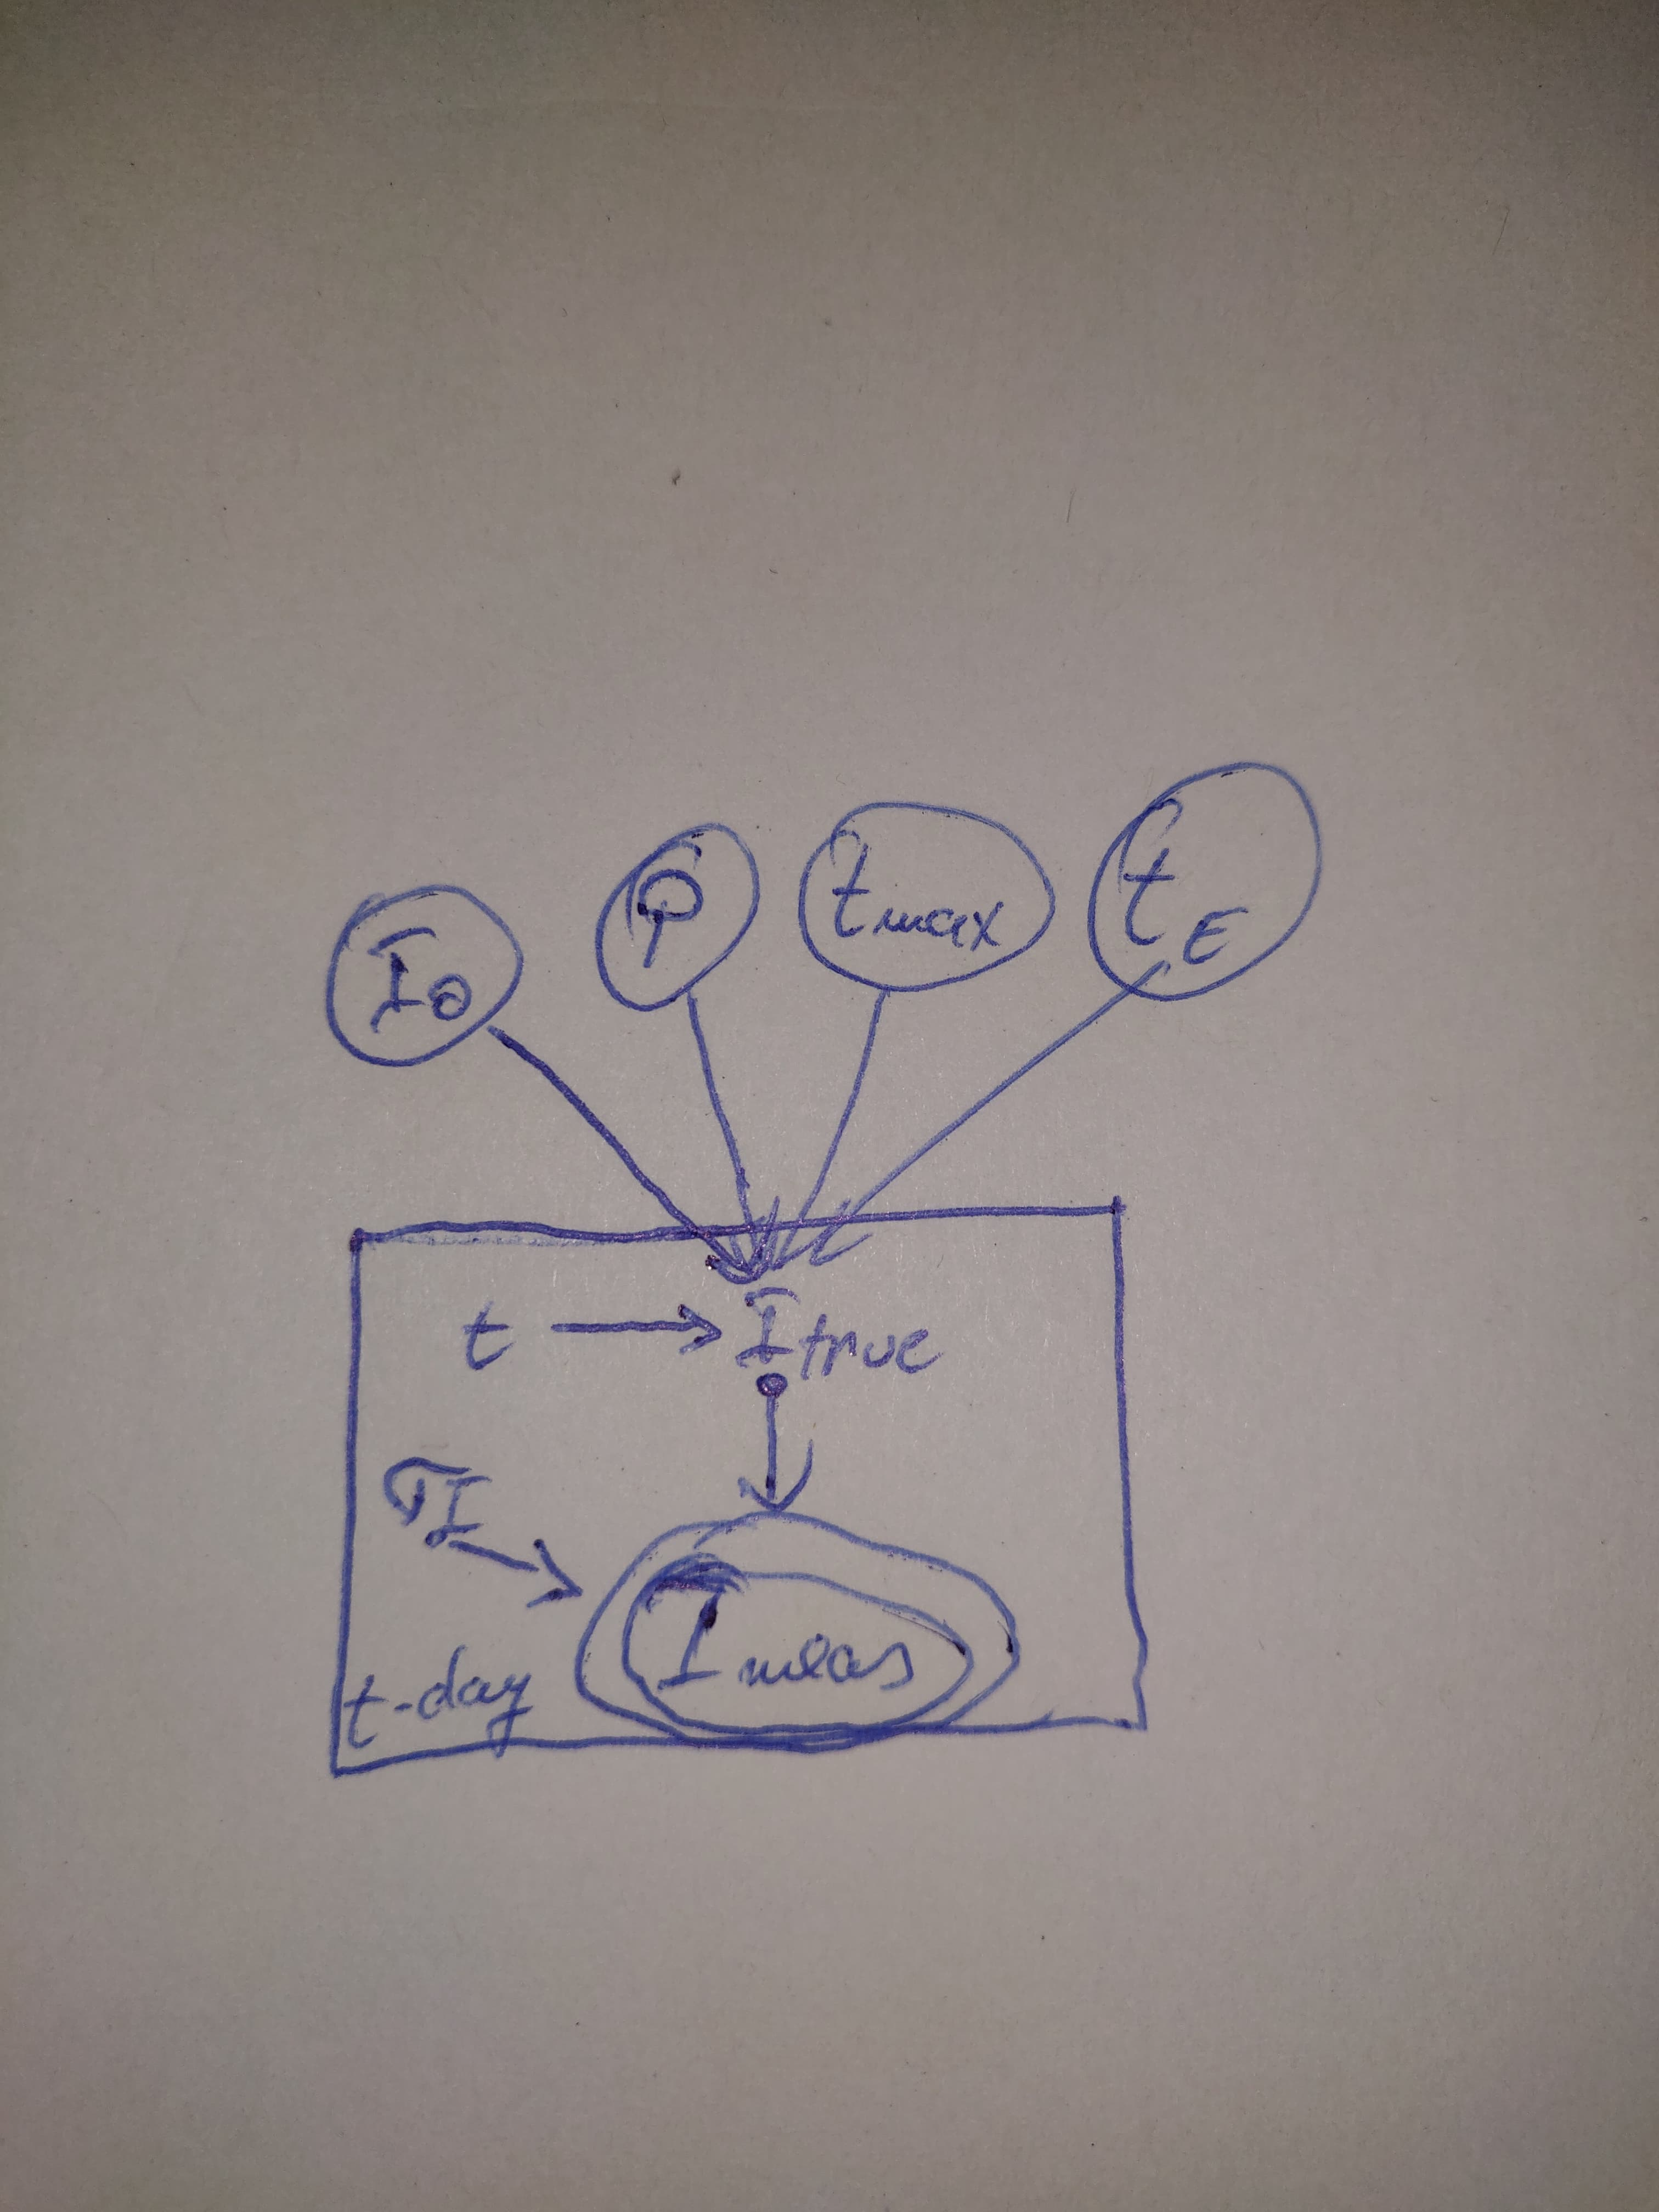

In [2]:
from IPython.display import Image

Image("PGM_Week3.jpg", width=600, height=600)

Imports

In [13]:
import numpy as np
import statsmodels.api as sm
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline
import time

/home/pdraghis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/pdraghis/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/pdraghis/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/pdraghis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/pdraghis/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/pdraghis/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486

Loading the text file and plotting

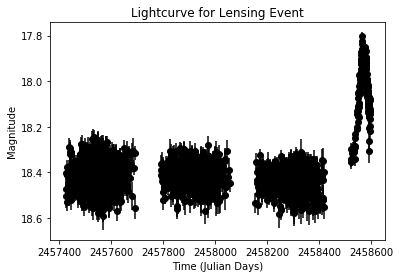

In [2]:
filename = "phot.dat"
file = np.loadtxt(filename)
plt.errorbar(file[:,0], file[:,1],yerr=file[:,2],fmt='ko')
plt.ylabel('Magnitude')
plt.xlabel('Time (Julian Days)')
plt.title('Lightcurve for Lensing Event')
plt.gca().invert_yaxis()

## 3. (Answer to 2 is below this)

Assigning uniform priors with values obtained from looking at the plot of the data itself for the magnitude and $t_{MAX}$, but using the textbook for noting that $p$ must be between 0.1 and 1.1, and obtainging the characteristic time on the order of a month.

Setting limits to uniform priors

In [3]:
mag_lo, mag_hi = 16,20
p_lo, p_hi = 0.1,1.1
t_max_lo, t_max_hi = 2458400,2458600
t_E_lo, t_E_hi = 10,50

Global variables for number of samples and initial guesses

In [64]:
N_SAMPLES = 1e6

MAG_0_GUESS = 18.4
P_GUESS = 0.5
T_MAX_GUESS = 2458570
T_E_GUESS = 30

## 2. Choosing uniform priors and a Gaussian likelihood

$$ P(I_{true}|I_{meas}) \propto P(I_{meas}|I_{true}) P(I_0) P(p) P(t_{true}) P(t_E)$$
$$ P(I_{meas}|I_{true}) = \prod_t \frac{1}{\sigma_I \sqrt{2\pi}} \exp[-\frac{1}{2} (\frac{I_{meas}-I_{true}}{\sigma_I})^2] $$

In [65]:
def lnPrior(params):
    mag_0 = params[0]
    p = params[1]
    t_max = params[2]
    t_E = params[3]
    if (mag_lo < mag_0 < mag_hi) and (p_lo < p < p_hi)\
    and (t_max_lo < t_max < t_max_hi) and (t_E_lo < t_E < t_E_hi):
        return 0
    return -np.inf

In [66]:
def lnLike(params, data):
    time = data[:,0]
    mag_meas = data[:,1]
    mag_sig = data[:,2]
    return -np.sum((mag_meas - mag_true(params, time))**2/(2*mag_sig**2)) - np.sum(np.log(mag_sig *np.sqrt(2*np.pi)))

def mag_true(params,t):
    mag_0, p, t_max, t_E = params[0],params[1],params[2],params[3]
    y=np.sqrt(p**2+((t-t_max)/t_E)**2)
    return mag_0 - 2.5*np.log10((y**2+2)/(y*np.sqrt(y**2+4)))

def lnPost(params, data):
    return lnLike(params, data) + lnPrior(params)

Testing by computing the log-likelihood at the guesses in order to see if it is low.

In [67]:
lnLike_test = lnLike(np.array([MAG_0_GUESS, P_GUESS, T_MAX_GUESS, T_E_GUESS]), file)
print(lnLike_test)

-4244.773783423949


In [68]:
def propose(params, width):
    return params + width * np.random.randn(params.shape[0])

In [69]:
def step(current_params, current_lnP, width=1e-3):
    trial_params = propose(current_params, width)
    trial_lnP = lnPost(trial_params, file)
    u = np.random.random_sample()
    if np.log(u) <= trial_lnP - current_lnP:
        return (trial_params, trial_lnP)
    else:
        return (current_params, current_lnP)

In [70]:
# choose an intial state and evaluate the posterior there
params = np.array([MAG_0_GUESS, P_GUESS, T_MAX_GUESS, T_E_GUESS])
lnP = lnPost(params, file)

# set up an array to hold the chain
samples = np.zeros((N_SAMPLES, 4))
tic=time.time()
# run the sampler
for i in range(N_SAMPLES):
    params, lnP = step(params, lnP)
    samples[i,:] = params
print('this took ',time.time()-tic,' seconds')

this took  305.3799502849579  seconds


## 4. Plots showing traces of each parameter

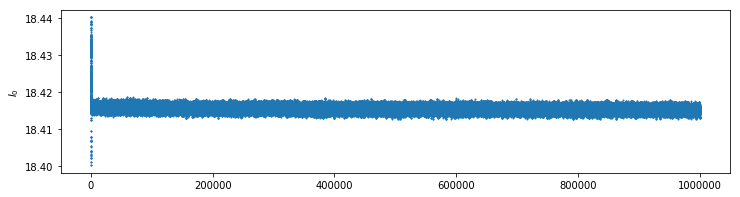

In [75]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.plot(samples[:,0], 'o', ms=1.0); plt.ylabel('$I_0$');

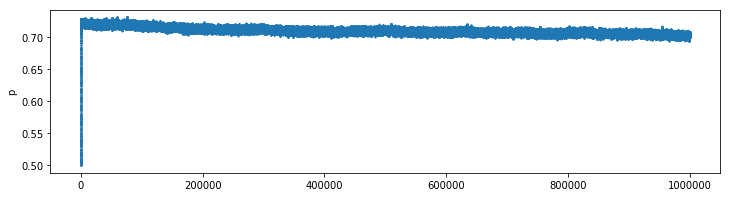

In [76]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.plot(samples[:,1], 'o', ms=1.0); plt.ylabel('p');

(2458560, 2458580)

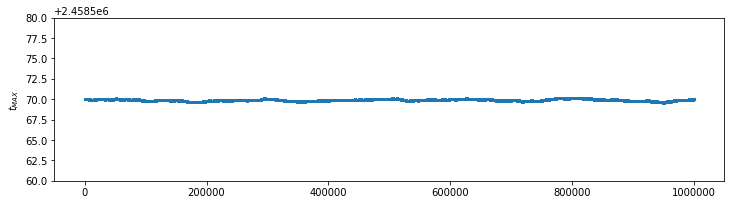

In [82]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.plot(samples[:,2], 'o', ms=1.0); plt.ylabel('$t_{MAX}$');
plt.ylim(2458560,2458580)

(25, 35)

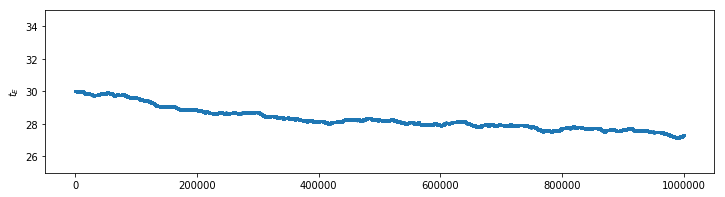

In [84]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.plot(samples[:,3], 'o', ms=1.0); plt.ylabel('$t_E$');
plt.ylim(25,35)

## 5. Comment on performance

Converged quite well, since the values the parameters are bouncing around are very low and there are no clear trends that indicate that we may have chosen priors that were too narrow.

Throwing out the burn-in period

In [85]:
samples = samples[np.arange(int(0.2*N_SAMPLES),N_SAMPLES),:]

## 6. 1D historgrams and 2D covariance plots to make one big corner plot

/home/pdraghis/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


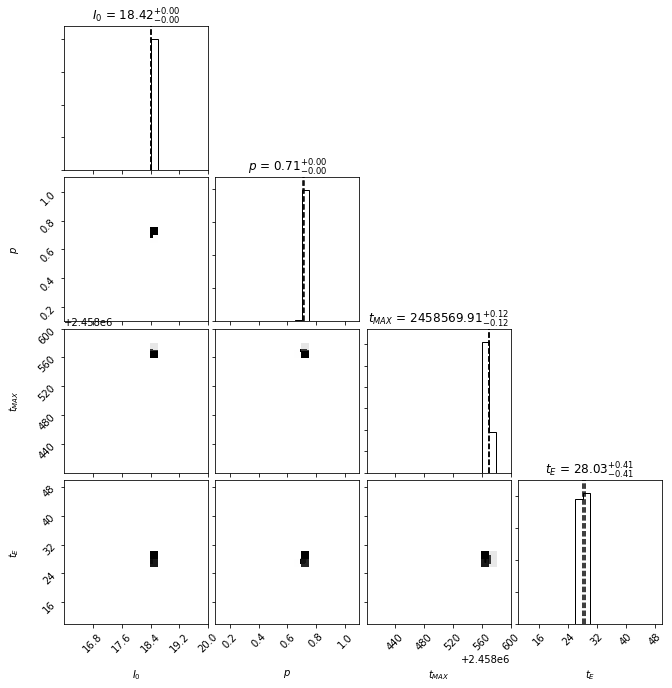

In [86]:
import corner
fig = corner.corner(samples, labels=[r"$I_0$", r"$p$", r"$t_{MAX}$", r"$t_E$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.68, 0.95],\
                       show_titles=True, title_kwargs={"fontsize": 12}, range=[(mag_lo,mag_hi), \
                        (p_lo,p_hi), (t_max_lo,t_max_hi), (t_E_lo,t_E_hi)])
fig.show()

## 7. Best fit values with CL obtained from the above corner plot.

$$I_0=18.42\pm 0.00$$
$$p=0.71 \pm 0.00$$
$$t_{max} = 2458569.91 \pm 0.12$$
$$t_E=28.03\pm 0.41$$

The uncertainties in the first two values seem absurdly small, but no other choice of initial guess, limits of the prior, width of the step size or length of iteration (we did a million steps) helps with that.

## 8. Plotting the lightcurve with the data

(18.7, 17.5)

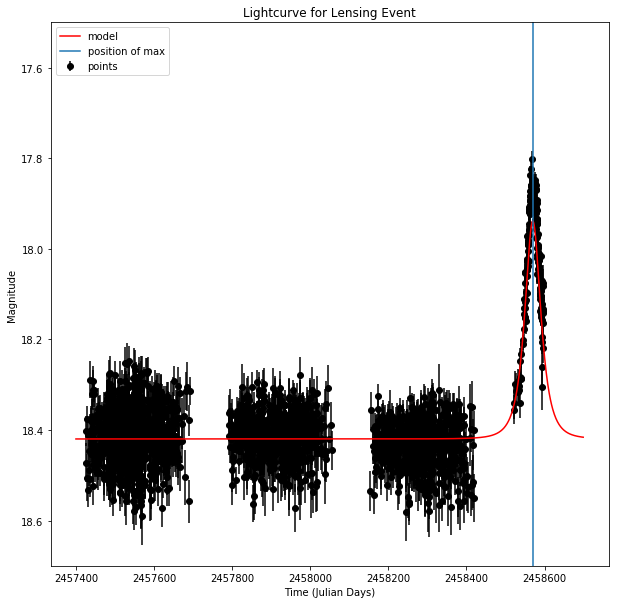

In [102]:
params_result=np.array([18.42,0.78,2458569.91,28.03])

times=np.arange(2457400,2458700)

mags=mag_true(params_result,times)

plt.figure(figsize=(10,10))
plt.errorbar(file[:,0], file[:,1],yerr=file[:,2],fmt='ko',zorder=1,label='points')
plt.plot(times,mags,'r',zorder=2,label='model')
plt.axvline(x=2458569.91,label='position of max')
plt.ylabel('Magnitude')
plt.xlabel('Time (Julian Days)')
plt.title('Lightcurve for Lensing Event')
plt.legend()
plt.ylim(18.7,17.5)

(2458540, 2458600)

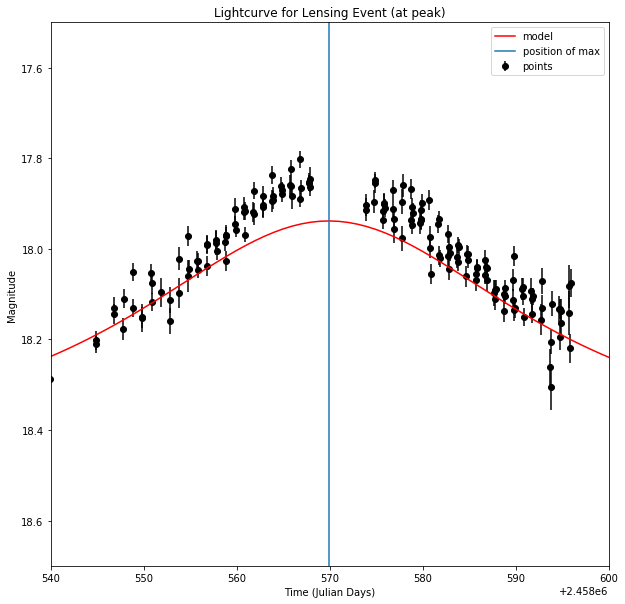

In [103]:
plt.figure(figsize=(10,10))
plt.errorbar(file[:,0], file[:,1],yerr=file[:,2],fmt='ko',zorder=1,label='points')
plt.plot(times,mags,'r',zorder=2,label='model')
plt.axvline(x=2458569.91,label='position of max')
plt.ylabel('Magnitude')
plt.xlabel('Time (Julian Days)')
plt.title('Lightcurve for Lensing Event (at peak)')
plt.legend()
plt.ylim(18.7,17.5)
plt.xlim(2458540,2458600)

it seems that the fit does a pretty good job overall, but at the peak of the lensing event does not quite model the shape of the peak right

### A gift

Here's a piece of code which will calculate the Gelman-Rubin convergence criterion ($R$) for a single parameter, if you pass it a `numpy.ndarray` where the first axis corresponds to different chains and the second axis corresponds to MCMC steps. It's not particularly flexible or optimal, so feel free to improve it or to write your own.

In [104]:
def gelmanrubin(chains):
    M = chains.shape[0]
    N = chains.shape[1]
    thetaJ = np.mean(chains,axis =1)
    thetabar = np.mean(chains)
    sJ = np.zeros(M)
    for i in range(0,M):
        sJ[i] = 1./(N-1.0)*np.sum(np.power(chains[i,:]-thetaJ[i],2.))
    W = 1./float(M)*np.sum(sJ)
    B = float(N)/(M-1.)*np.sum(np.power(thetaJ-thetabar,2.0))
    vartheta = float(N-1)/float(N)*W +B/float(N)
    return np.sqrt(vartheta/W)

Seems to converge pretty well, since the "recommonded" value is 0.3, and this is on the order of that.

In [105]:
print(gelmanrubin(samples))

0.8660254037844425
